In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
OL_phase = np.load('../data/OutLoop/OL_Phase.npy')
OL_amp = np.load('../data/OutLoop/OL_Magnitude.npy')
OL_e = np.load('../data/OutLoop/OL_Energy.npy')
IL_phase = np.load('../data/OutLoop/IL_Phase.npy')
IL_amp = np.load('../data/OutLoop/IL_Magnitude.npy')
IL_e = np.load('../data/OutLoop/IL_energy.npy')
Laser_amp = np.load('../data/OutLoop/Laser_Amp.npy')
Laser_phase = np.load('../data/OutLoop/Laser_Phs.npy')

In [3]:
y1 = np.load('../data/OutLoop/CameraFit.npy')
y2 = np.load('../data/OutLoop/CameraProj.npy')

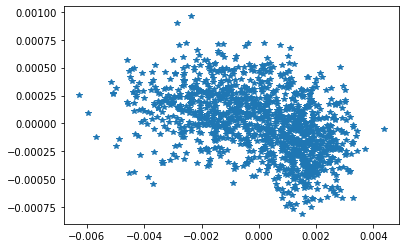

In [4]:
plt.plot(Laser_amp,y1,'*')

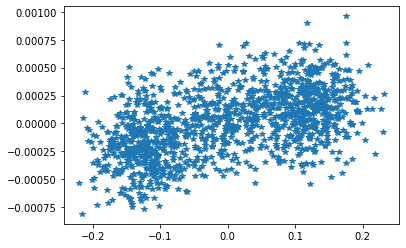

In [5]:
plt.plot(OL_e,y1,'*')

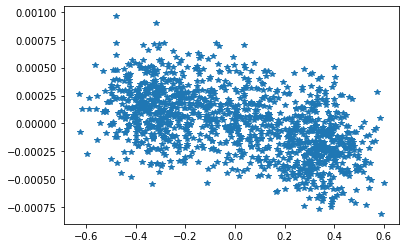

In [6]:
plt.plot(OL_phase,y1,'*')

In [7]:
#x = np.concatenate((OL_phase, OL_amp,OL_e,IL_phase,IL_amp,IL_e,Laser_phase,Laser_amp), axis=0)
x = np.concatenate((OL_phase,OL_e,Laser_amp), axis=0)
X = x.reshape([y1.shape[0],-1])

In [8]:
Y = y1.reshape([y1.shape[0],-1])

## normalize data

In [9]:
mu_X = np.mean(X, axis=0)
sigma_X = np.std(X, axis=0)
_X = (X - mu_X)/sigma_X

In [10]:
mu_Y = np.mean(Y, axis=0)
sigma_Y = np.std(Y, axis=0)
_Y = (Y - mu_Y) / sigma_Y

In [11]:
_X.shape,_Y.shape

((1303, 3), (1303, 1))

In [12]:
print('rms focus distance',sigma_Y)

rms focus distance [0.00028934]


### Make pytorch datasets based on the data

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from pytorchtools import EarlyStopping

In [14]:
class PhasedegDataset(Dataset):

    def __init__(self, X, Y):
        self.len = X.shape[0]
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.len

In [15]:
phase_deg_dataset = PhasedegDataset(_X, _Y)

In [16]:
total_num = len(phase_deg_dataset)

vali_num = int(0.1 * total_num)
test_num = int(0.1 * total_num)
train_num = total_num - vali_num - test_num

train_num, vali_num, test_num

(1043, 130, 130)

In [17]:
train_dataset, vali_dataset, test_dataset = random_split(phase_deg_dataset, [train_num, vali_num, test_num])

### set up dataloader

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### make a model

In [19]:
class FocusModel(nn.Module):
    # Phase to image model

    def __init__(self):
        super(FocusModel, self).__init__()
        self.fc1 = nn.Linear(_X.shape[1], 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, _Y.shape[1])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         print("\tIn Model: input size", input.size(),
#               "output size", output.size())

        return x

In [20]:
net = FocusModel()
net = net.float()
net.to(device)

FocusModel(
  (fc1): Linear(in_features=3, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

In [21]:
neurals_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(neurals_num)

761


### loss function and optimazer

In [22]:
import torch.optim as optim

In [23]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

---

### train the data

In [25]:

# ## with early stop

def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
            
        for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a tuple of (input, target)
            inputs, targets = data[0].float().to(device), data[1].float().to(device)        
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            # calculate the loss
            loss = torch.sqrt(criterion(outputs, targets))*sigma_Y[0]
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data in valid_loader:
            inputs, targets = data[0].float().to(device), data[1].float().to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            # calculate the loss
            loss = torch.sqrt(criterion(outputs, targets))*sigma_Y[0]
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # save training info to the npy files
        with open('train_loss.npy', 'wb') as f:
            np.save(f, avg_train_losses)
        with open('valid_loss.npy', 'wb') as f:
            np.save(f, avg_valid_losses)
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [26]:
batch_size = 2
n_epochs = 1000

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=vali_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 15
model, train_loss, valid_loss = train_model(net, batch_size, patience, n_epochs)

[   1/1000] train_loss: 0.82034 valid_loss: 0.85385
Validation loss decreased (inf --> 0.853847).  Saving model ...
[   2/1000] train_loss: 0.79677 valid_loss: 0.80950
Validation loss decreased (0.853847 --> 0.809505).  Saving model ...
[   3/1000] train_loss: 0.79286 valid_loss: 0.81546
EarlyStopping counter: 1 out of 15
[   4/1000] train_loss: 0.79121 valid_loss: 0.80028
Validation loss decreased (0.809505 --> 0.800278).  Saving model ...
[   5/1000] train_loss: 0.78948 valid_loss: 0.81595
EarlyStopping counter: 1 out of 15
[   6/1000] train_loss: 0.79007 valid_loss: 0.78664
Validation loss decreased (0.800278 --> 0.786642).  Saving model ...
[   7/1000] train_loss: 0.79349 valid_loss: 0.79689
EarlyStopping counter: 1 out of 15
[   8/1000] train_loss: 0.78630 valid_loss: 0.79724
EarlyStopping counter: 2 out of 15
[   9/1000] train_loss: 0.79026 valid_loss: 0.81087
EarlyStopping counter: 3 out of 15
[  10/1000] train_loss: 0.78946 valid_loss: 0.80453
EarlyStopping counter: 4 out of 15

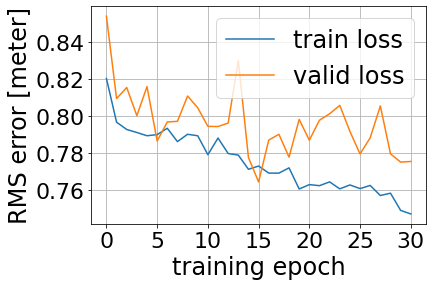

In [27]:
train_losses = np.load('train_loss.npy')
valid_losses = np.load('valid_loss.npy')

fs = 24
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(train_losses,label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')

ax.set_xlabel('training epoch',fontsize = fs)
ax.set_ylabel('RMS error [meter]',fontsize = fs)
plt.grid(True)
plt.xticks(fontsize=fs-2 )
plt.yticks(fontsize=fs-2 )
plt.legend(fontsize = fs,loc='best')
#plt.legend(fontsize = fs,loc='best', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
#plt.savefig(save_loss_fig,dpi = 200, bbox_inches='tight')

### try predict

In [28]:
def NN_predict(X):
    _X = (X - mu_X) / sigma_X
    _Y = net(torch.from_numpy(_X).float()).detach().numpy()
   # print(f"Runtime of the program is {end - start}")
    D_pred = _Y * sigma_Y + mu_Y
    return D_pred

In [29]:
x = np.concatenate((OL_phase,OL_e,Laser_amp), axis=0)
xreal = x.reshape([y1.shape[0],-1])

In [30]:
yreal = y2.reshape([y1.shape[0],-1])

In [31]:
ypred = NN_predict(xreal)

Text(0, 0.5, 'predict (um)')

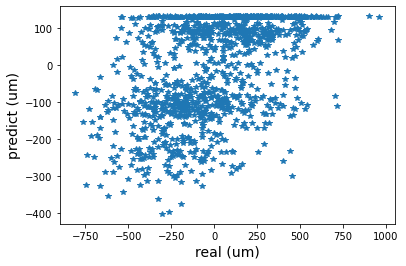

In [32]:
plt.plot(yreal*1e6,ypred*1e6,'*')
plt.xlabel('real (um)',fontsize = 14)
plt.ylabel('predict (um)',fontsize = 14)